In [1]:
import numpy as np
from pprint import pprint
from copy import deepcopy


from laboneq.contrib.example_helpers.generate_descriptor import generate_descriptor
#from laboneq.contrib.example_helpers.generate_device_setup import generate_device_setup
from laboneq.dsl.device import DeviceSetup
from laboneq.simple import *
from laboneq.dsl.device import DeviceSetup
from laboneq.dsl.calibration import Oscillator, SignalCalibration
from laboneq.dsl.enums import ModulationType




# descriptor = generate_descriptor(
#     #pqsc=[""], # 장비 여러개 사용시
#     shfqc_6=["DEV12256"], 
#     number_data_qubits=3,
#     multiplex=True,
#     number_multiplex=6,
#     include_cr_lines=False,
#     include_ef_lines=True,
#     get_zsync=False,  # Only set to True when using real device
#     save = True,
#     filename="1port",
#     ip_address="192.168.0.83"
# )


#descriptor
#setup = DeviceSetup.from_descriptor(yaml_text=descriptor, server_host="192.168.0.83")
setup = DeviceSetup.from_yaml(filepath="/Users/yalgaeahn/JSAHN/qubit-experiment/examples/selectiveRIP/Descriptors/1port.yaml" , server_host="192.168.0.83")
#setup
setup.instruments[0].device_options = 'SHFQC/PLUS/QC6CH'
#setup.instruments

In [2]:
bus_ids = [f"b{i}" for i in range(3)]
bus_port = [4,5,6] #used 1,2,3 for qubit drive

for i, bus in zip(bus_port,bus_ids):
    setup.add_connections(
        setup.instruments[0].uid,
        # each bus uses its own drive:
        create_connection(
            to_signal=f"{bus}/drive",
            ports=f"SGCHANNELS/{i}/OUTPUT"
        ))

# Calibrate qubit drive/measure lines for oscillator phase increments
qubit_ids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
for qubit in qubit_ids:
    for line, frequency, mod_type in [
        ("drive", 5e9, ModulationType.HARDWARE),
        ("drive_ef", 6e9, ModulationType.HARDWARE),
        ("measure", 4e9, ModulationType.SOFTWARE),
    ]:
        logical_signal = setup.logical_signal_by_uid(f"{qubit}/{line}")
        oscillator = Oscillator(modulation_type=mod_type)
        logical_signal.calibration = SignalCalibration(
            local_oscillator=Oscillator(frequency=frequency),
            oscillator=oscillator,
        )
        if line == "measure":
            acquire_signal = setup.logical_signal_by_uid(f"{qubit}/acquire")
            acquire_signal.calibration = SignalCalibration(
                local_oscillator=Oscillator(frequency=frequency),
                oscillator=oscillator,
            )


In [3]:
from qpu_types.fixed_transmon import FixedTransmonQubit, FixedTransmonQubitParameters
from qpu_types.bus_cavity import BusCavity, BusCavityParameters
from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
from laboneq.dsl.quantum.qpu import QPU, QuantumPlatform
from helper import load_qubit_parameters, save_qubit_parameters

qubit_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
bus_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("b")]

qubits = FixedTransmonQubit.from_device_setup(
    setup, qubit_uids=qubit_uids)
buses = BusCavity.from_device_setup(
    setup, qubit_uids=bus_uids)

qpu = QPU(quantum_elements={"qubits" : qubits, "bus" : buses}, quantum_operations=[FixedTransmonOperations, BusCavityOperations])


# from laboneq.simple import workflow
# folder_store = workflow.logbook.FolderStore("./experiment_store") 
# folder_store.activate()
# #folder_store.deactivate()
# #workflow.logbook.LoggingStore().activate()
# #workflow.logbook.LogbookStore().deactivate()


# LOAD QPU

In [4]:
import os
from datetime import datetime
def find_latest_json(folder_path):
    files = [f for f in os.listdir(folder_path)]
    timestamps = []
    for file in files:
        try:
            # Extract a timestamp assuming it's included in the filename
            timestamp_str = file.split('_', 1)[0]  # Assuming YYYYMMDDHHMMSS format
            timestamp = datetime.strptime(timestamp_str, '%Y%m%d-%H%M%S')
            timestamps.append((timestamp, file))
        except ValueError:
            print("fuck")
            continue  # Skip files that do not match the timestamp format

       # Find the most recent file
    if timestamps:
        latest_file = max(timestamps, key=lambda x: x[0])[1]
        return os.path.join(folder_path, latest_file)
    return None

qb_pars_file = find_latest_json("./qpu_parameters/")
print(f"LOADED: {qb_pars_file}")

from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
import laboneq.dsl.quantum.qpu as qpu_mod

class CombinedOperations(FixedTransmonOperations, BusCavityOperations):
    pass

qpu_mod.CombinedOperations = CombinedOperations

qpu = load(qb_pars_file)

buses = qpu.groups.bus
qubits = qpu.groups.qubits


from laboneq.simple import workflow
folder_store = workflow.logbook.FolderStore("./experiment_store")
folder_store.activate()

fuck
LOADED: ./qpu_parameters/20260210-1641_2q_qst


# CONNECTION

In [5]:
from laboneq.simple import Session
session = Session(setup)
session.connect(ignore_version_mismatch=False, do_emulation=False)
#session.disconnect()

[2026.02.10 20:59:07.237] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is /Users/yalgaeahn/JSAHN/qubit-experiment/examples/selectiveRIP/laboneq_output/log
[2026.02.10 20:59:07.239] INFO    VERSION: laboneq 25.10.3
[2026.02.10 20:59:07.240] INFO    Connecting to data server at 192.168.0.83:8004
[2026.02.10 20:59:07.272] INFO    Connected to Zurich Instruments LabOne Data Server version 25.10.1.4 at 192.168.0.83:8004
[2026.02.10 20:59:07.332] INFO    Configuring the device setup
[2026.02.10 20:59:07.581] INFO    The device setup is configured


In [6]:
from experiments import iq_blobs

## IQ Blobs 기반 Threshold Calibration 실행 예제

이 노트북은 `time_traces` 없이 `iq_blobs`만으로 threshold를 계산하고, 필요시 QPU 파라미터에 반영한 뒤 `DISCRIMINATION`에서 0/1 결과를 확인하는 흐름을 보여줍니다.

실행 순서:
1. `update=False`로 threshold 계산 결과만 확인
2. `update=True`로 `readout_integration_discrimination_thresholds` 반영
3. `AcquisitionType.DISCRIMINATION`으로 실제 0/1 출력 확인


In [7]:
# 사용할 qubit 선택
q = qubits[0]
print(f"Target qubit: {q.uid}")
print("Current readout_integration_kernels_type:", q.parameters.readout_integration_kernels_type)
print("Current readout_integration_discrimination_thresholds:", q.parameters.readout_integration_discrimination_thresholds)


Target qubit: q0
Current readout_integration_kernels_type: default
Current readout_integration_discrimination_thresholds: None


### 1) Threshold 계산만 수행 (`update=False`)

`states='ge'` single-shot IQ를 사용해 threshold를 계산합니다.
이 단계에서는 QPU 파라미터를 바꾸지 않고 분석 결과만 확인합니다.


In [8]:
options = iq_blobs.experiment_workflow.options()
options.count(2**12)
options.do_analysis(True)
options.update(False)

temporary_parameters = {}
temp_pars =deepcopy(q.parameters)

wf = iq_blobs.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    states="ge",
    options=options,
    temporary_parameters=temporary_parameters
)
wf_result = wf.run()

analysis_out = wf_result.tasks["analysis_workflow"].output
print("\n[analysis output keys]", list(analysis_out.keys()))
print("\n[discrimination_thresholds]")
pprint(analysis_out["discrimination_thresholds"])
print("\n[proposed parameter update]")
pprint(analysis_out["qubit_parameters"]["new_parameter_values"])

print("\nQPU parameter is unchanged because update=False")
print("readout_integration_discrimination_thresholds:", qpu[q.uid].parameters.readout_integration_discrimination_thresholds)


[2026.02.10 20:59:08.545] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.10 20:59:08.545] INFO      Workflow 'iq_blobs': execution started at 2026-02-10 11:59:08.545073Z         
[2026.02.10 20:59:08.546] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.10 20:59:08.556] INFO    Task 'temporary_qpu': started at 2026-02-10 11:59:08.556694Z
[2026.02.10 20:59:08.557] INFO    Task 'temporary_qpu': ended at 2026-02-10 11:59:08.557751Z
[2026.02.10 20:59:08.560] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2026-02-10 
[2026.02.10 20:59:08.560] INFO    11:59:08.560102Z
[2026.02.10 20:59:08.561] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2026-02-10 11:59:08.560893Z
[2026.02.10 20:59:08.562] INFO    Task 'create_experiment': started at 2026-02-10 11:59:08.562034Z
[2026.02.10 20:59:08.586] INFO    Task 'create_experiment': ended at 2026-02-10 11:59:08.586043Z
[202

### 2) 계산된 Threshold를 QPU에 반영 (`update=True`)

이 단계에서는 `analysis_workflow`가 만든 `qubit_parameters`를 사용해
`readout_integration_discrimination_thresholds`를 실제 QPU 파라미터에 반영합니다.
또한 커널 타입은 `default`(constant kernel)로 강제됩니다.


In [9]:
options_apply = iq_blobs.experiment_workflow.options()
options_apply.count(2**12)
options_apply.do_analysis(True)
options_apply.update(True)




wf_apply = iq_blobs.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    states="ge",
    options=options_apply,
)
wf_apply_result = wf_apply.run()
analysis_out = wf_apply_result.tasks["analysis_workflow"].output
print(analysis_out["discrimination_thresholds"])
print(analysis_out["qubit_parameters"]["new_parameter_values"])
print(qpu[q.uid].parameters.readout_integration_discrimination_thresholds)


print("Updated readout_integration_kernels_type:", qpu[q.uid].parameters.readout_integration_kernels_type)
print("Updated readout_integration_discrimination_thresholds:", qpu[q.uid].parameters.readout_integration_discrimination_thresholds)


[2026.02.10 20:59:10.982] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.10 20:59:10.982] INFO      Workflow 'iq_blobs': execution started at 2026-02-10 11:59:10.981958Z         
[2026.02.10 20:59:10.983] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.10 20:59:10.992] INFO    Task 'temporary_qpu': started at 2026-02-10 11:59:10.992241Z
[2026.02.10 20:59:10.993] INFO    Task 'temporary_qpu': ended at 2026-02-10 11:59:10.993337Z
[2026.02.10 20:59:10.995] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2026-02-10 
[2026.02.10 20:59:10.996] INFO    11:59:10.995657Z
[2026.02.10 20:59:10.996] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2026-02-10 11:59:10.996353Z
[2026.02.10 20:59:10.998] INFO    Task 'create_experiment': started at 2026-02-10 11:59:10.998406Z
[2026.02.10 20:59:11.014] INFO    Task 'create_experiment': ended at 2026-02-10 11:59:11.014225Z
[202

larger real integrated values map to |g| than |e|
이건 threshold는 계산됨을 의미합니다.
단지 분류 축 방향이 반대라는 뜻입니다(0/1 의미가 뒤집힐 수 있음).

### 3) `DISCRIMINATION` 모드에서 0/1 출력 확인

반영된 threshold 기준으로 acquisition 결과가 0/1로 나오는지 확인합니다.
(에뮬레이터에서는 물리값 의미가 제한적일 수 있습니다.)


In [11]:
from laboneq.dsl.enums import AcquisitionType

options_discr = iq_blobs.experiment_workflow.options()
options_discr.count(2**10)
options_discr.acquisition_type(AcquisitionType.DISCRIMINATION)
options_discr.do_analysis(False)
options_discr.update(False)

wf_discr = iq_blobs.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    states="ge",
    options=options_discr,
)
wf_discr_result = wf_discr.run()

# Workflow 결과 래퍼/페이로드 형태를 모두 처리
if hasattr(wf_discr_result, "tasks") and "run_experiment" in wf_discr_result.tasks:
    run_result = wf_discr_result.tasks["run_experiment"].output
else:
    run_result = getattr(wf_discr_result, "output", wf_discr_result)

h_g = dsl.handles.calibration_trace_handle(q.uid, "g")
h_e = dsl.handles.calibration_trace_handle(q.uid, "e")

g_bits = np.clip(np.rint(np.real(np.asarray(run_result[h_g].data))), 0, 1).astype(int)
e_bits = np.clip(np.rint(np.real(np.asarray(run_result[h_e].data))), 0, 1).astype(int)

print("unique(g):", np.unique(g_bits), "sample:", g_bits[:20])
print("unique(e):", np.unique(e_bits), "sample:", e_bits[:20])

assert set(np.unique(g_bits)).issubset({0, 1})
assert set(np.unique(e_bits)).issubset({0, 1})
print("OK: discrimination outputs are binary (0/1).")


[2026.02.10 20:59:14.182] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.10 20:59:14.182] INFO      Workflow 'iq_blobs': execution started at 2026-02-10 11:59:14.181938Z         
[2026.02.10 20:59:14.183] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.10 20:59:14.193] INFO    Task 'temporary_qpu': started at 2026-02-10 11:59:14.192935Z
[2026.02.10 20:59:14.194] INFO    Task 'temporary_qpu': ended at 2026-02-10 11:59:14.194678Z
[2026.02.10 20:59:14.197] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2026-02-10 
[2026.02.10 20:59:14.198] INFO    11:59:14.197807Z
[2026.02.10 20:59:14.198] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2026-02-10 11:59:14.198660Z
[2026.02.10 20:59:14.200] INFO    Task 'create_experiment': started at 2026-02-10 11:59:14.199950Z
[2026.02.10 20:59:14.207] INFO    Task 'create_experiment': ended at 2026-02-10 11:59:14.207550Z
[202

## 4) Threshold 분류 검증 (SW vs HW)

아래 셀은 같은 qubit에 대해 다음을 비교합니다.
- SW: `INTEGRATION` IQ의 real 축에 threshold를 적용해 분류한 결과
- HW: `DISCRIMINATION` 모드에서 장비가 반환한 0/1 결과

두 confusion matrix와 fidelity가 유사하면 threshold 분류가 정상 동작한다고 볼 수 있습니다.


In [12]:
import numpy as np
from laboneq.dsl.enums import AcquisitionType
from laboneq.simple import dsl

def _unwrap_result_like(obj):
    cur = obj
    for _ in range(8):
        if hasattr(cur, "output"):
            cur = cur.output
            continue
        return cur
    return cur

def _get_run_payload(wf_result):
    # run_experiment task 출력이 있으면 우선 사용
    if hasattr(wf_result, "tasks") and "run_experiment" in wf_result.tasks:
        return _unwrap_result_like(wf_result.tasks["run_experiment"].output)
    return _unwrap_result_like(getattr(wf_result, "output", wf_result))

def _cm2(y_true, y_pred):
    cm = np.zeros((2, 2), dtype=float)
    for t, p in zip(y_true, y_pred):
        cm[int(t), int(p)] += 1.0
    row_sums = cm.sum(axis=1, keepdims=True)
    with np.errstate(invalid="ignore", divide="ignore"):
        cm_n = cm / np.maximum(row_sums, 1.0)
    fidelity = float(np.trace(cm_n) / 2.0)
    return cm_n, fidelity

q = qubits[0]

# (A) INTEGRATION + analysis로 threshold 추출
opt_int = iq_blobs.experiment_workflow.options()
opt_int.count(2**12)
opt_int.do_analysis(True)
opt_int.update(False)

wf_int = iq_blobs.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    states="ge",
    options=opt_int,
)
res_int = wf_int.run()
analysis_out = _unwrap_result_like(res_int.tasks["analysis_workflow"].output)
thr_info = analysis_out["discrimination_thresholds"][q.uid]
threshold = float(thr_info["threshold"])
high_state = str(thr_info["high_state"])

run_payload_int = _get_run_payload(res_int)
h_g = dsl.handles.calibration_trace_handle(q.uid, "g")
h_e = dsl.handles.calibration_trace_handle(q.uid, "e")
g_iq = np.asarray(run_payload_int[h_g].data).reshape(-1)
e_iq = np.asarray(run_payload_int[h_e].data).reshape(-1)
x = np.concatenate([np.real(g_iq), np.real(e_iq)])
y_true = np.concatenate([np.zeros(len(g_iq), dtype=int), np.ones(len(e_iq), dtype=int)])
if high_state == "e":
    y_pred_sw = (x >= threshold).astype(int)
else:
    y_pred_sw = (x < threshold).astype(int)

cm_sw, fid_sw = _cm2(y_true, y_pred_sw)

# (B) DISCRIMINATION으로 실제 0/1 획득
opt_dis = iq_blobs.experiment_workflow.options()
opt_dis.count(2**12)
opt_dis.acquisition_type(AcquisitionType.DISCRIMINATION)
opt_dis.do_analysis(False)
opt_dis.update(False)

wf_dis = iq_blobs.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    states="ge",
    options=opt_dis,
)
res_dis = wf_dis.run()
run_payload_dis = _get_run_payload(res_dis)
g_bits = np.clip(np.rint(np.real(np.asarray(run_payload_dis[h_g].data))), 0, 1).astype(int).reshape(-1)
e_bits = np.clip(np.rint(np.real(np.asarray(run_payload_dis[h_e].data))), 0, 1).astype(int).reshape(-1)
y_true_hw = np.concatenate([np.zeros(len(g_bits), dtype=int), np.ones(len(e_bits), dtype=int)])
y_pred_hw = np.concatenate([g_bits, e_bits])
cm_hw, fid_hw = _cm2(y_true_hw, y_pred_hw)

print(f"q={q.uid}, threshold={threshold:.6g}, high_state={high_state}")
print("\n[SW threshold classification]\n", cm_sw)
print(f"SW fidelity={fid_sw:.4f}")
print("\n[HW discrimination classification]\n", cm_hw)
print(f"HW fidelity={fid_hw:.4f}")
print("\nAbs fidelity diff =", abs(fid_sw - fid_hw))


[2026.02.10 21:05:46.440] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.10 21:05:46.440] INFO      Workflow 'iq_blobs': execution started at 2026-02-10 12:05:46.439840Z         
[2026.02.10 21:05:46.441] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.10 21:05:46.454] INFO    Task 'temporary_qpu': started at 2026-02-10 12:05:46.454215Z
[2026.02.10 21:05:46.456] INFO    Task 'temporary_qpu': ended at 2026-02-10 12:05:46.456574Z
[2026.02.10 21:05:46.459] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2026-02-10 
[2026.02.10 21:05:46.460] INFO    12:05:46.459573Z
[2026.02.10 21:05:46.461] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2026-02-10 12:05:46.461133Z
[2026.02.10 21:05:46.463] INFO    Task 'create_experiment': started at 2026-02-10 12:05:46.463121Z
[2026.02.10 21:05:46.487] INFO    Task 'create_experiment': ended at 2026-02-10 12:05:46.487461Z
[202

### SW/HW Confusion Matrix 시각화

이 셀은 직전 셀에서 계산한 `cm_sw`, `cm_hw`를 heatmap으로 나란히 표시합니다.


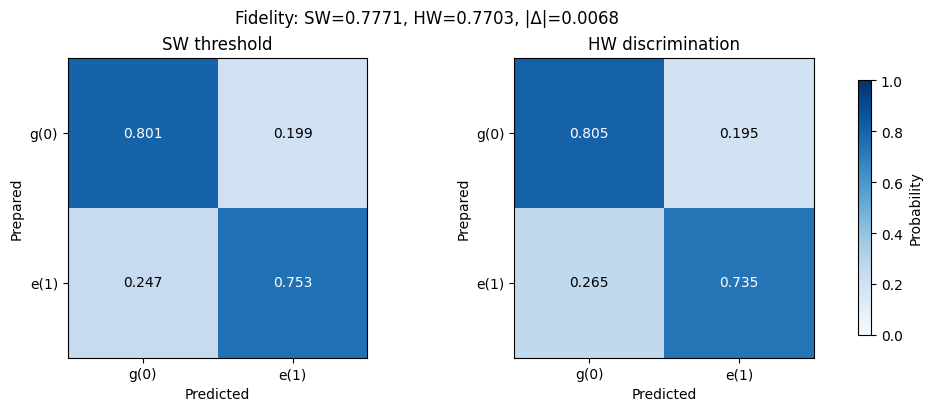

In [13]:
import matplotlib.pyplot as plt
import numpy as np

if "cm_sw" not in globals() or "cm_hw" not in globals():
    raise RuntimeError("먼저 직전 검증 셀(Section 4 코드)을 실행해 cm_sw/cm_hw를 계산하세요.")

fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
mats = [(cm_sw, "SW threshold"), (cm_hw, "HW discrimination")]

for ax, (cm, title) in zip(axes, mats):
    im = ax.imshow(cm, cmap="Blues", vmin=0.0, vmax=1.0)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Prepared")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["g(0)", "e(1)"])
    ax.set_yticklabels(["g(0)", "e(1)"])
    for i in range(2):
        for j in range(2):
            color = "white" if cm[i, j] > 0.5 else "black"
            ax.text(j, i, f"{cm[i, j]:.3f}", ha="center", va="center", color=color)

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.85)
cbar.set_label("Probability")

if "fid_sw" in globals() and "fid_hw" in globals():
    fig.suptitle(f"Fidelity: SW={fid_sw:.4f}, HW={fid_hw:.4f}, |Δ|={abs(fid_sw-fid_hw):.4f}")

plt.show()
